# Imports

In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from source.Prototype1 import Prototype1
from source.F import JointAutoencoder

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math
from PIL import Image
from collections import deque
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter, label, generate_binary_structure
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.ndimage import label as ndi_label, binary_dilation


/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Init variables

In [2]:
autoencoder = JointAutoencoder()
ground_truth = NEUDataset(set="clustered/train", seed=1234, scale=1)
train_images = NEUDataset(set="train", seed=1234, scale=0.5)

print(len(ground_truth))
print(len(train_images))

total_parametros = sum(p.numel() for p in autoencoder.parameters())
print(f"Model parameters: {total_parametros}")

Dataset: clustered/train created!
Dataset: train created!
1656
1656
Model parameters: 21329924


/home/liingfeng/Desktop/repos/moe_edging/source/F.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.param_estimator.load_state_dict(torch.load("h2.pth", map_location

# Hyperparameters

In [3]:
LEARNING_RATE = 0.005 #0.00005
EPOCH = 1000
BATCH_SIZE = len(ground_truth)//2
THREADS = 8

# Training

In [4]:
ground_truth_loader = DataLoader(dataset=ground_truth, batch_size=BATCH_SIZE, shuffle=True, num_workers=THREADS) # __getitem__ return image, _ (useless)
train_images_loader = DataLoader(dataset=train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=THREADS)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder.to(device)
criterion = nn.MSELoss(reduction="mean")  # Compara la imagen original con la reconstruida
optimizer = Adam(autoencoder.parameters(), lr=LEARNING_RATE)

In [ ]:
autoencoder.train()  # Modo entrenamiento

for epoch in range(EPOCH):
    running_loss = 0.0
    # Iteramos simultáneamente sobre los DataLoaders
    for (inputs, _), (targets, _) in zip(train_images_loader, ground_truth_loader):
        inputs = (inputs).to(device)
        targets = (targets).to(device)
        #print("Input shape", inputs.shape)
        #print("Target shape",targets.shape)
        outputs = autoencoder(inputs)         # Propagación hacia adelante
        #print("output shape", outputs.shape)

        loss = criterion(outputs, targets)  # Cálculo de la pérdida

        optimizer.zero_grad()         # Reinicia los gradientes
        loss.backward()               # Retropropagación
        optimizer.step()              # Actualización de parámetros
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_images_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCH}], Loss: {epoch_loss:.4f}")

Epoch [1/1000], Loss: 0.1192
Epoch [2/1000], Loss: 0.1171
Epoch [3/1000], Loss: 0.1151
Epoch [4/1000], Loss: 0.1130
Epoch [5/1000], Loss: 0.1108
Epoch [6/1000], Loss: 0.1083
Epoch [7/1000], Loss: 0.1059
Epoch [8/1000], Loss: 0.1034
Epoch [9/1000], Loss: 0.1007
Epoch [10/1000], Loss: 0.0982
Epoch [11/1000], Loss: 0.0954
Epoch [12/1000], Loss: 0.0928
Epoch [13/1000], Loss: 0.0904
Epoch [14/1000], Loss: 0.0878
Epoch [15/1000], Loss: 0.0856
Epoch [16/1000], Loss: 0.0830
Epoch [17/1000], Loss: 0.0811
Epoch [18/1000], Loss: 0.0789
Epoch [19/1000], Loss: 0.0768
Epoch [20/1000], Loss: 0.0749
Epoch [21/1000], Loss: 0.0731
Epoch [22/1000], Loss: 0.0714
Epoch [23/1000], Loss: 0.0699
Epoch [24/1000], Loss: 0.0684
Epoch [25/1000], Loss: 0.0670
Epoch [26/1000], Loss: 0.0656
Epoch [27/1000], Loss: 0.0645
Epoch [28/1000], Loss: 0.0634
Epoch [29/1000], Loss: 0.0622
Epoch [30/1000], Loss: 0.0614
Epoch [31/1000], Loss: 0.0605
Epoch [32/1000], Loss: 0.0595
Epoch [33/1000], Loss: 0.0588
Epoch [34/1000], Lo

Exception ignored in: <function _releaseLock at 0x71f78d7a2ca0>
Traceback (most recent call last):
  File "/usr/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Epoch [70/1000], Loss: 0.0493
Epoch [71/1000], Loss: 0.0492
Epoch [72/1000], Loss: 0.0491
Epoch [73/1000], Loss: 0.0491
Epoch [74/1000], Loss: 0.0489
Epoch [75/1000], Loss: 0.0488
Epoch [76/1000], Loss: 0.0489
Epoch [77/1000], Loss: 0.0488
Epoch [78/1000], Loss: 0.0488
Epoch [79/1000], Loss: 0.0488
Epoch [80/1000], Loss: 0.0487
Epoch [81/1000], Loss: 0.0487


# Test

In [8]:
test_set = NEUDataset(set="test", seed=1234, scale=0.5)
image, label = test_set.__getitem__(index=1)

original_image = image.detach().cpu().numpy()[0]

Dataset: test created!


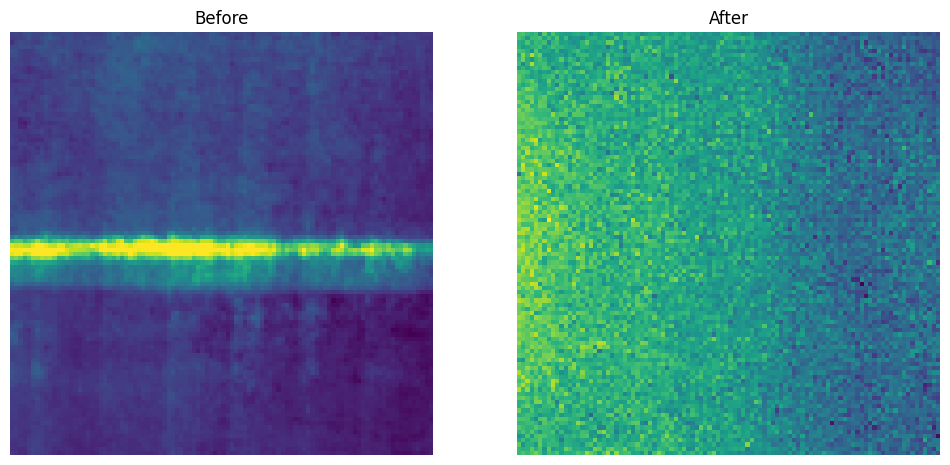

In [10]:
clustered_image = autoencoder(image.to("cuda").unsqueeze(1)).squeeze(1).detach().cpu().numpy()
clustered_image = Perspectiver.rgb_to_grayscale(Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(clustered_image[0])))

Perspectiver.plotComparison(imageBefore=original_image, imageAfter=clustered_image)